In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from math import sqrt
import warnings
warnings.filterwarnings("ignore")

In [21]:
# ------------------------------
# 1. Cargar datos
# ------------------------------
df = pd.read_csv("TempNY (1).csv")

# Detectar columna fecha
for col in df.columns:
    try:
        df[col] = pd.to_datetime(df[col])
        df = df.set_index(col)
        break
    except:
        pass

# Tomar primera columna numérica como serie
serie = df.select_dtypes(include=[np.number]).iloc[:, 0].dropna()



In [9]:
# ------------------------------
# 2. Separar entrenamiento y prueba (90%)
# ------------------------------
n = len(serie)
split = int(n * 0.9)
train = serie.iloc[:split]
test = serie.iloc[split:]


In [11]:

# ------------------------------
# 3. Prueba Dickey-Fuller
# ------------------------------
def adf_test(x):
    res = adfuller(x, autolag="AIC")
    return res[0], res[1]

d = 0
serie_aux = train.copy()

print("Prueba Dickey-Fuller:")
while True:
    stat, pvalue = adf_test(serie_aux.dropna())
    print(f"d = {d} | Estadístico ADF = {stat:.4f} | p-value = {pvalue:.4f}")
    if pvalue < 0.05:
        break
    serie_aux = serie_aux.diff()
    d += 1


Prueba Dickey-Fuller:
d = 0 | Estadístico ADF = -1.7177 | p-value = 0.4220
d = 1 | Estadístico ADF = -8.4606 | p-value = 0.0000


In [13]:
# ------------------------------
# 4. Comparación ARIMA(p,d,q) con AIC
# ------------------------------
resultados = []

for p in range(0, 4):
    for q in range(0, 4):
        try:
            model = SARIMAX(train, order=(p, d, q),
                            enforce_stationarity=False,
                            enforce_invertibility=False)
            res = model.fit(disp=False)
            resultados.append([p, d, q, res.aic])
        except:
            continue

aic_df = pd.DataFrame(resultados, columns=["p", "d", "q", "AIC"])
aic_df = aic_df.sort_values("AIC")
aic_df.head(6)

,p,d,q,AIC
15,3,1,3,417.914903
11,2,1,3,418.615827
3,0,1,3,424.000014
2,0,1,2,425.002703
1,0,1,1,425.591783
7,1,1,3,425.980338


In [15]:
# ------------------------------
# 5. Ajustar mejor modelo
# ------------------------------
p_opt, d_opt, q_opt = aic_df.iloc[0][["p", "d", "q"]]

modelo = SARIMAX(train, order=(p_opt, d_opt, q_opt),
                 enforce_stationarity=False,
                 enforce_invertibility=False)
fit = modelo.fit(disp=False)

# ------------------------------
# 6. Pronósticos
# ------------------------------
h = len(test)
forecast = fit.get_forecast(steps=h)
pred = forecast.predicted_mean
conf_int = forecast.conf_int()

pred.index = test.index
conf_int.index = test.index

In [17]:
# ------------------------------
# 7. Métricas de error
# ------------------------------
mae = np.mean(np.abs(test - pred))
rmse = sqrt(np.mean((test - pred) ** 2))
mape = np.mean(np.abs((test - pred) / test)) * 100

print("\nMétricas de error:")
print(f"MAE  = {mae:.4f}")
print(f"RMSE = {rmse:.4f}")
print(f"MAPE = {mape:.2f}%")



Métricas de error:
MAE  = 1.1366
RMSE = 1.3462
MAPE = 2.01%


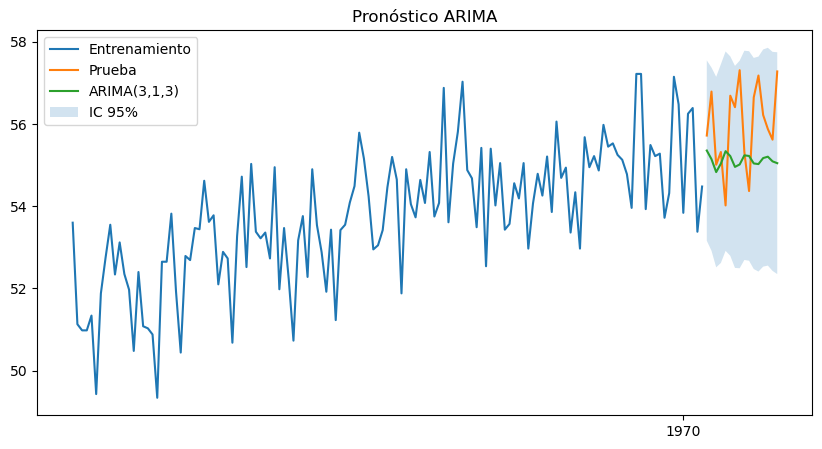

In [19]:
# ------------------------------
# 8. Gráfica final
# ------------------------------
plt.figure(figsize=(10, 5))
plt.plot(train, label="Entrenamiento")
plt.plot(test, label="Prueba")
plt.plot(pred, label=f"ARIMA({int(p_opt)},{int(d_opt)},{int(q_opt)})")
plt.fill_between(conf_int.index,
                 conf_int.iloc[:, 0],
                 conf_int.iloc[:, 1],
                 alpha=0.2,
                 label="IC 95%")
plt.legend()
plt.title("Pronóstico ARIMA")
plt.show()